<a href="https://colab.research.google.com/github/Henkin2th/AIPI-590.05-Assignement/blob/main/ML_assignment_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Churn Prediction - Google Colab Notebook**
This notebook explores and models customer churn for a telecom company using multiple machine learning methods. We'll perform:

1.   Exploratory Data Analysis (EDA)
2.   Linear Regression
3.   Logistic Regression
4.   Generalized Additive Model (GAM)
5.   Model Comparison


# **Setup the Environment**

In [1]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


# **Import Libraries and Load Dataset**
The dataset contains customer information, including whether they churned (`Churn`), their contract details, monthly charges, and other services.

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, mean_squared_error
from sklearn.preprocessing import StandardScaler
from pygam import LogisticGAM, s
from pygam import LinearGAM, s
from sklearn.metrics import r2_score

# Load dataset from GitHub
url = "https://raw.githubusercontent.com/Henkin2th/AIPI-590.05-Assignement/main/ML/WA_Fn-UseC_-Telco-Customer-Churn.csv"
data = pd.read_csv(url)

# Show the first few rows of the dataset
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **Data Preprocessing**

In [11]:
# Dropping 'customerID' as it's not relevant for analysis
data.drop('customerID', axis=1, inplace=True)

# Converting 'TotalCharges' to numeric, coercing errors to NaN and dropping missing values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.dropna(inplace=True)

# Convert 'Churn' to binary: 0 for 'No', 1 for 'Yes'
data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# One-hot encode categorical variables
data = pd.get_dummies(data, drop_first=True)

# Check the processed data
data.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


# **Exploratory Data Analysis (EDA)**
Let's plot a correlation matrix to understand the relationships between the variables.

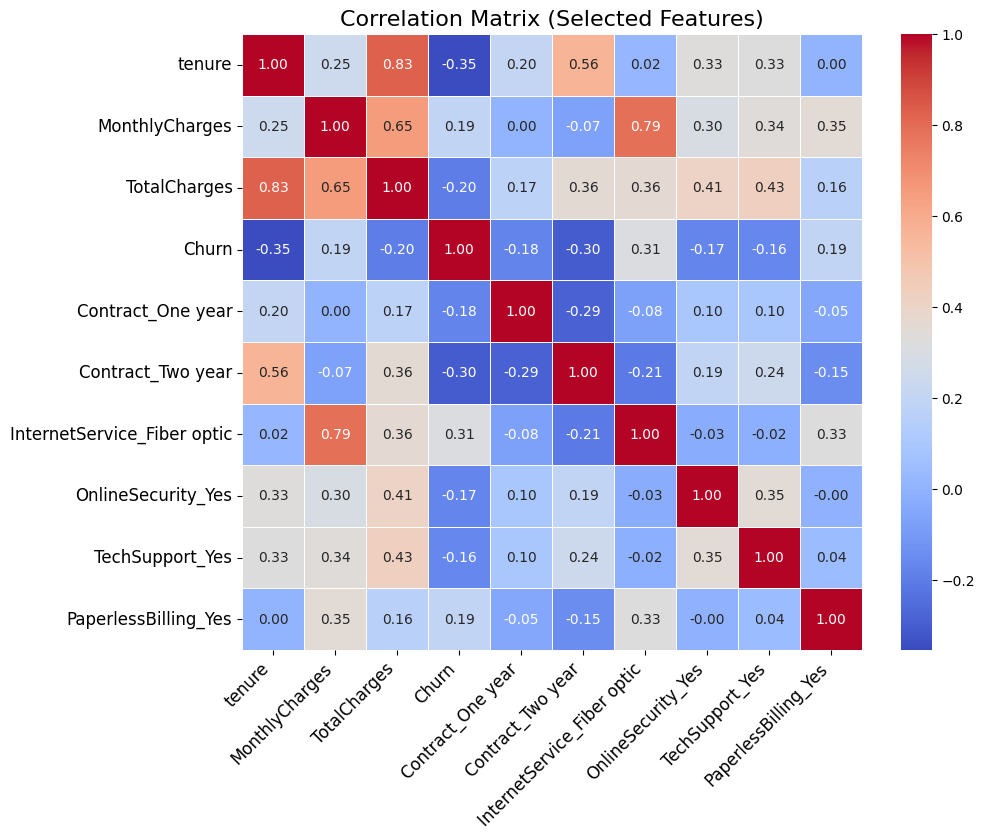

In [12]:
# Select key features for correlation analysis
key_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
                'Contract_One year', 'Contract_Two year',
                'InternetService_Fiber optic', 'OnlineSecurity_Yes',
                'TechSupport_Yes', 'PaperlessBilling_Yes']

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data[key_features].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (Selected Features)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# **Feature Selection for Modeling**
We'll now select the features and target variable (`Churn`) and split the dataset into training and test sets.

In [13]:
# Define features and target variable
X = data.drop('Churn', axis=1)
y = data['Churn']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Linear Regression**

In [14]:
# Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate Linear Regression model
mse = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression Mean Squared Error (MSE): {mse}")

# Interpret the coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': linear_model.coef_})
print("Linear Regression Coefficients:")
print(coefficients.sort_values(by='Coefficient', ascending=False))

Linear Regression Mean Squared Error (MSE): 0.14341706959785855
Linear Regression Coefficients:
                                  Feature  Coefficient
10            InternetService_Fiber optic     0.132694
23                    StreamingMovies_Yes     0.042461
21                        StreamingTV_Yes     0.041908
9                       MultipleLines_Yes     0.030235
28         PaymentMethod_Electronic check     0.025184
0                           SeniorCitizen     0.017299
26                   PaperlessBilling_Yes     0.013657
5                             Partner_Yes     0.009907
17                   DeviceProtection_Yes     0.006652
7                        PhoneService_Yes     0.006509
15                       OnlineBackup_Yes     0.004164
4                             gender_Male    -0.001448
27  PaymentMethod_Credit card (automatic)    -0.004981
29             PaymentMethod_Mailed check    -0.005070
8          MultipleLines_No phone service    -0.006509
14       OnlineBackup_No

# **Logistic Regression**
Logistic regression is a more suitable model for predicting binary outcomes such as `Churn`.

Logistic Regression Accuracy: 0.79478672985782
Logistic Regression ROC-AUC: 0.8392189084096577


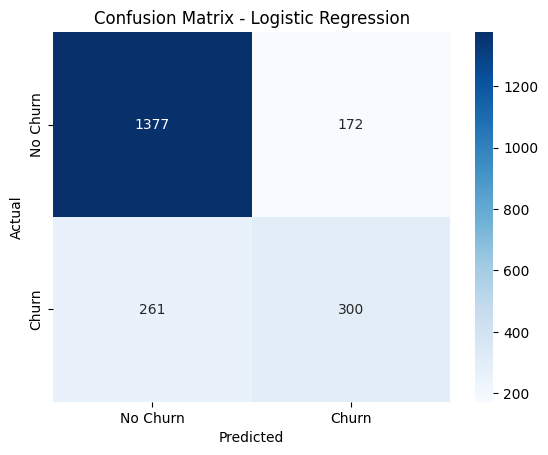

In [15]:
# Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_logistic = logistic_model.predict(X_test_scaled)
y_pred_prob_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate Logistic Regression model
accuracy = accuracy_score(y_test, y_pred_logistic)
roc_auc = roc_auc_score(y_test, y_pred_prob_logistic)
print(f"Logistic Regression Accuracy: {accuracy}")
print(f"Logistic Regression ROC-AUC: {roc_auc}")

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# **Generalized Additive Model (GAM)**
We'll now use the GAM model to capture non-linear relationships in the data.

In [18]:

# Initialize a LinearGAM with smoothing terms for each selected feature
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9))

# Perform a grid search to find the best smoothing parameters
gam.gridsearch(X_train_scaled, y_train)

# Fit the model using the optimal parameters
gam.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_gam = gam.predict(X_test_scaled)

# Evaluate the GAM performance using MSE and R²
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam)

print(f"GAM Mean Squared Error (MSE): {mse_gam:.4f}")
print(f"GAM R-squared (R²): {r2_gam:.4f}")

gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


GAM Mean Squared Error (MSE): 0.1455
GAM R-squared (R²): 0.2544
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     28.5935
Link Function:                     IdentityLink Log Likelihood:                                -12360.0852
Number of Samples:                         4922 AIC:                                            24779.3574
                                                AICc:                                           24779.7276
                                                GCV:                                                0.1411
                                                Scale:                                              0.1396
                                                Pseudo R-Squared:               

<ipython-input-18-2763f66d2c06>:20: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


# **Model Comparison**
Finally, we will compare the performance of the three models.

In [20]:
# Model Comparison
print("\nModel Performance Comparison:")
print(f"Linear Regression MSE: {mse}")
print(f"Logistic Regression Accuracy: {accuracy}, ROC-AUC: {roc_auc}")
print(f"GAM Mean Squared Error (MSE): {mse_gam:.4f}, R-squared (R²): {r2_gam:.4f}")


Model Performance Comparison:
Linear Regression MSE: 0.14341706959785855
Logistic Regression Accuracy: 0.79478672985782, ROC-AUC: 0.8392189084096577
GAM Mean Squared Error (MSE): 0.1455, R-squared (R²): 0.2544
